# In this Notebook we are going to:
1- Read files which contians datasets.
<br>
2- Merge these files together to generate the full dataset.
<br>
3- Applying feature engineering techniques to fill the ***Null*** cells.
<br>
4- Fix the unbalancing of the data.
<br>
5- Applying feature selection and ranking techniques.
<br>

In [ ]:

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle competitions download -c kkbox-churn-prediction-challenge

 99% 229M/231M [00:02<00:00, 114MB/s]
100% 231M/231M [00:02<00:00, 97.7MB/s]
  0% 0.00/6.88k [00:00<?, ?B/s]
100% 6.88k/6.88k [00:00<00:00, 5.86MB/s]
 89% 28.0M/31.3M [00:00<00:00, 57.3MB/s]
100% 31.3M/31.3M [00:00<00:00, 89.9MB/s]
 89% 28.0M/31.3M [00:00<00:00, 63.1MB/s]
100% 31.3M/31.3M [00:00<00:00, 88.1MB/s]
 99% 665M/675M [00:04<00:00, 126MB/s]
100% 675M/675M [00:04<00:00, 143MB/s]
 72% 21.0M/29.2M [00:00<00:00, 59.6MB/s]
100% 29.2M/29.2M [00:00<00:00, 112MB/s] 
100% 654M/654M [00:05<00:00, 121MB/s]
100% 654M/654M [00:05<00:00, 135MB/s]
 90% 42.0M/46.6M [00:00<00:00, 69.9MB/s]
100% 46.6M/46.6M [00:00<00:00, 103MB/s] 
 78% 25.0M/32.0M [00:00<00:00, 68.6MB/s]
100% 32.0M/32.0M [00:00<00:00, 80.8MB/s]
  5% 323M/6.65G [00:02<01:32, 73.2MB/s]

In [ ]:
'''
!7z e members_v3.csv.7z
!7z e sample_submission_v2.csv.7z
!7z e train_v2.csv.7z
!7z e transactions_v2.csv.7z
!7z e user_logs_v2.csv.7z
'''

'\n!7z e members_v3.csv.7z\n!7z e sample_submission_v2.csv.7z\n!7z e train_v2.csv.7z\n!7z e transactions_v2.csv.7z\n!7z e user_logs_v2.csv.7z\n'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from pandas_profiling import ProfileReport

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

import datetime as dt

% matplotlib inline
seed = 129

# Gathering Data

In [ ]:
train = pd.read_csv('train_v2.csv',dtype={'is_churn':np.int8})
test = pd.read_csv('sample_submission_v2.csv',dtype={'is_churn':np.int8})
members = pd.read_csv('members_v3.csv',parse_dates=['registration_init_time'],dtype={'city':np.int8,'bd':np.int8,
                                                                                         'registered_via':np.int8})
transactions = pd.read_csv('transactions_v2.csv',parse_dates=['transaction_date','membership_expire_date'],
                          dtype={'payment_method_id':np.int8,'payment_plan_days':np.int8,'plan_list_price':np.int8,
                                'actual_amount_paid':np.int8,'is_auto_renew':np.int8,'is_cancel':np.int8})

user_log = pd.read_csv('user_logs_v2.csv',parse_dates=['date'],dtype={'num_25':np.int16,'num_50':np.int16,
                                    'num_75':np.int16,'num_985':np.int16,'num_100':np.int16,'num_unq':np.int16})

# Explore Data sets

In [ ]:
print('Number of rows  & columns',train.shape)
train.head()

Number of rows  & columns (970960, 2)


,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [ ]:
print('Number of rows  & columns',test.shape)
test.head()

Number of rows  & columns (907471, 2)


,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [ ]:
print('Number of rows  & columns',members.shape)
members.head()

Number of rows  & columns (6769473, 6)


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,2011-09-15
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,2011-09-15


In [ ]:
print('Number of rows & columns',transactions.shape)
transactions.head()

Number of rows & columns (1431009, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,42,42,0,2017-01-31,2017-05-04,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,-107,-107,1,2015-08-09,2019-04-12,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,-76,-76,1,2017-03-03,2017-04-22,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,-76,-76,1,2017-03-29,2017-03-31,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,2017-03-23,2017-04-23,0


In [ ]:
print('Number of rows & columns',user_log.shape)
user_log.head()

Number of rows & columns (18396362, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,2017-03-31,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,2017-03-30,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,2017-03-31,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,2017-03-31,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,2017-03-31,2,1,0,1,112,93,28401.558


In [ ]:
print('\nTrain:',train.describe().T)
print('\nTest:',test.describe().T)
print('\nMembers:',members.describe().T)
print('\nTransactions:',transactions.describe().T)
print('\nUser log:',user_log.describe().T)


Train:              count      mean       std  min  25%  50%  75%  max
is_churn  970960.0  0.089942  0.286099  0.0  0.0  0.0  0.0  1.0

Test:              count  mean  std  min  25%  50%  75%  max
is_churn  907471.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Members:                     count      mean        std    min  25%  50%   75%    max
city            6769473.0  3.847358   5.478359    1.0  1.0  1.0   4.0   22.0
bd              6769473.0  9.763688  15.354561 -128.0  0.0  0.0  21.0  126.0
registered_via  6769473.0  5.253069   2.361398   -1.0  4.0  4.0   7.0   19.0

Transactions:                         count       mean        std  ...   50%   75%    max
payment_method_id   1431009.0  37.918355   4.964805  ...  40.0  41.0   41.0
payment_plan_days   1431009.0  18.432050  39.830162  ...  30.0  30.0  120.0
plan_list_price     1431009.0 -21.387690  94.768896  ... -76.0  99.0  126.0
actual_amount_paid  1431009.0 -20.556024  94.926916  ... -76.0  99.0  127.0
is_auto_renew       1431009.0   0.

# Merge Data sets

In [ ]:
train = pd.merge(train,members,on='msno',how='left')
test = pd.merge(test,members,on='msno',how='left')
train = pd.merge(train,transactions,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,transactions,how='left',on='msno',left_index=True, right_index=True,)
train = pd.merge(train,user_log,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,user_log,how='left',on='msno',left_index=True, right_index=True)

del members,transactions,user_log
print('Number of rows & columns',train.shape)
print('Number of rows & columns',test.shape)

Number of rows & columns (970960, 23)
Number of rows & columns (907471, 23)


# Data featurs

In [ ]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].describe()

,registration_init_time,transaction_date,membership_expire_date,date
count,860967,970960,970960,970960
unique,4749,820,1818,31
top,2015-10-09 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-03-30 00:00:00
freq,1575,130414,79283,32331
first,2004-03-26 00:00:00,2015-01-01 00:00:00,2016-04-20 00:00:00,2017-03-01 00:00:00
last,2017-04-24 00:00:00,2017-03-31 00:00:00,2036-10-15 00:00:00,2017-03-31 00:00:00


In [ ]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].isnull().sum()

registration_init_time    109993
transaction_date               0
membership_expire_date         0
date                           0
dtype: int64

In [ ]:
train['registration_init_time'] = train['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))
test['registration_init_time'] = test['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))

In [ ]:
def date_feature(df):
    
    col = ['registration_init_time' ,'transaction_date','membership_expire_date','date']
    var = ['reg','trans','mem_exp','user_'] 
    
    for i ,j in zip(col,var):
        df[j+'_day'] = df[i].dt.day.astype('uint8')
        df[j+'_weekday'] = df[i].dt.weekday.astype('uint8')        
        df[j+'_month'] = df[i].dt.month.astype('uint8') 
        df[j+'_year'] =df[i].dt.year.astype('uint16') 

date_feature(train)
date_feature(test)

# explore Data analysis And Handling Missing Value




In [ ]:
train.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel', 'date',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'reg_day', 'reg_weekday', 'reg_month', 'reg_year',
       'trans_day', 'trans_weekday', 'trans_month', 'trans_year',
       'mem_exp_day', 'mem_exp_weekday', 'mem_exp_month', 'mem_exp_year',
       'user__day', 'user__weekday', 'user__month', 'user__year'],
      dtype='object')

In [ ]:
train.isnull().sum()

msno                           0
is_churn                       0
city                      109993
bd                        109993
gender                    582055
registered_via            109993
registration_init_time         0
payment_method_id              0
payment_plan_days              0
plan_list_price                0
actual_amount_paid             0
is_auto_renew                  0
transaction_date               0
membership_expire_date         0
is_cancel                      0
date                           0
num_25                         0
num_50                         0
num_75                         0
num_985                        0
num_100                        0
num_unq                        0
total_secs                     0
reg_day                        0
reg_weekday                    0
reg_month                      0
reg_year                       0
trans_day                      0
trans_weekday                  0
trans_month                    0
trans_year

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 39 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   msno                    970960 non-null  object        
 1   is_churn                970960 non-null  int8          
 2   city                    860967 non-null  float64       
 3   bd                      860967 non-null  float64       
 4   gender                  388905 non-null  object        
 5   registered_via          860967 non-null  float64       
 6   registration_init_time  970960 non-null  datetime64[ns]
 7   payment_method_id       970960 non-null  int8          
 8   payment_plan_days       970960 non-null  int8          
 9   plan_list_price         970960 non-null  int8          
 10  actual_amount_paid      970960 non-null  int8          
 11  is_auto_renew           970960 non-null  int8          
 12  transaction_date        970960

In [ ]:
col = [ 'city', 'bd', 'gender', 'registered_via']
def missing(df,columns):
    col = columns
    for i in col:
        df[i].fillna(df[i].mode()[0],inplace=True)

missing(train,col)
missing(test,col)

In [ ]:
def unique_value(df):
    col = df.columns
    for i in col:
        print('Number of unique value in {} is {}'.format(i,df[i].nunique()))

unique_value(train)

Number of unique value in msno is 970960
Number of unique value in is_churn is 2
Number of unique value in city is 21
Number of unique value in bd is 186
Number of unique value in gender is 2
Number of unique value in registered_via is 5
Number of unique value in registration_init_time is 4749
Number of unique value in payment_method_id is 37
Number of unique value in payment_plan_days is 30
Number of unique value in plan_list_price is 44
Number of unique value in actual_amount_paid is 47
Number of unique value in is_auto_renew is 2
Number of unique value in transaction_date is 820
Number of unique value in membership_expire_date is 1818
Number of unique value in is_cancel is 2
Number of unique value in date is 31
Number of unique value in num_25 is 361
Number of unique value in num_50 is 179
Number of unique value in num_75 is 94
Number of unique value in num_985 is 218
Number of unique value in num_100 is 586
Number of unique value in num_unq is 430
Number of unique value in total_se

Text(0.5, 0, 'The subscription within 30 days of expiration is True/False')

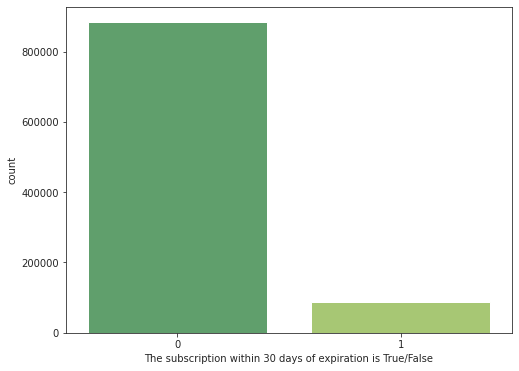

In [ ]:
plt.figure(figsize=(8,6))
sns.set_style('ticks')
sns.countplot(train['is_churn'],palette='summer')
plt.xlabel('The subscription within 30 days of expiration is True/False')



```
# This is formatted as code
```

### we notice that this is an imbalance data set

# Univariate analysis

[ 5. 13.  1. 22.  9. 12.  6. 14.  4. 15. 18.  3. 21.  8.  7. 17. 11. 10.
 20. 16. 19.]


Text(0.5, 0, 'Payment_method_id')

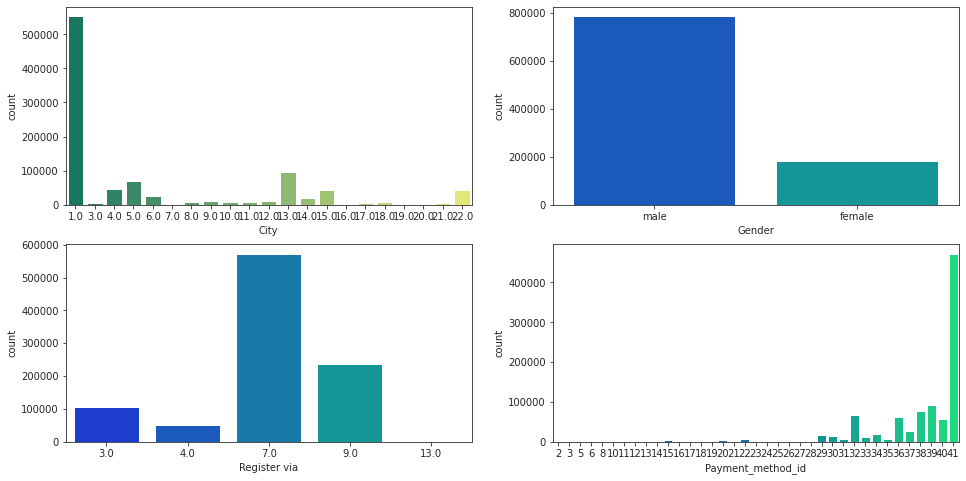

In [ ]:
print(train['city'].unique())
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()

sns.set(style="ticks")
sns.countplot(train['city'],palette='summer',ax=ax1)
#ax1.set_yscale('log')

ax1.set_xlabel('City')
#ax1.set_xticks(rotation=45)

sns.countplot(x='gender',data = train,palette='winter',ax=ax2)
#ax2.set_yscale('log')
ax2.set_xlabel('Gender')

sns.countplot(x='registered_via',data=train,palette='winter',ax=ax3)
#ax3.set_yscale('')
ax3.set_xlabel('Register via')

sns.countplot(x='payment_method_id',data= train,palette='winter',ax=ax4)
ax4.set_xlabel('Payment_method_id')

In [ ]:
print(train['bd'].describe())

count    970960.000000
mean         11.941948
std          15.811148
min        -128.000000
25%           0.000000
50%           0.000000
75%          26.000000
max         126.000000
Name: bd, dtype: float64


Text(0.5, 1.0, 'Distribution of birth day')

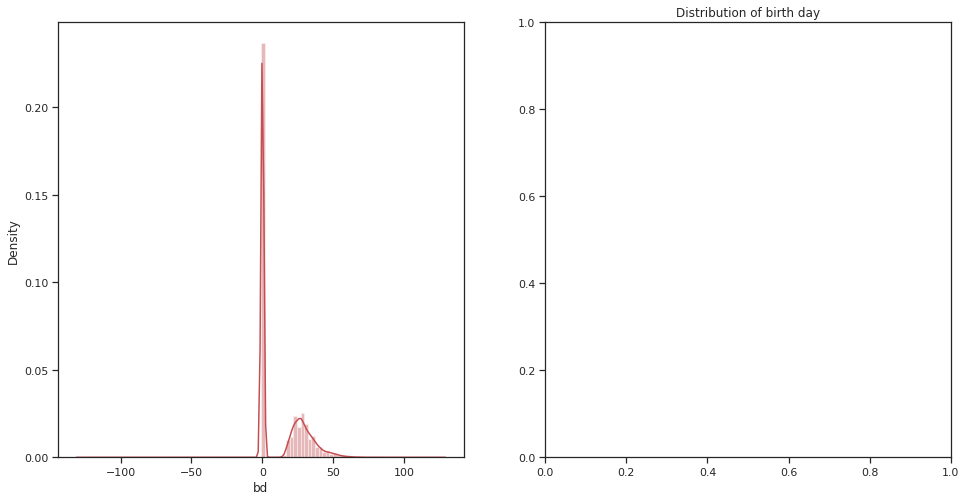

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
sns.set_style('ticks')
sns.distplot(train['bd'].fillna(train['bd'].mode()[0]),bins=100,color='r',ax=ax1)
plt.title('Distribution of birth day')

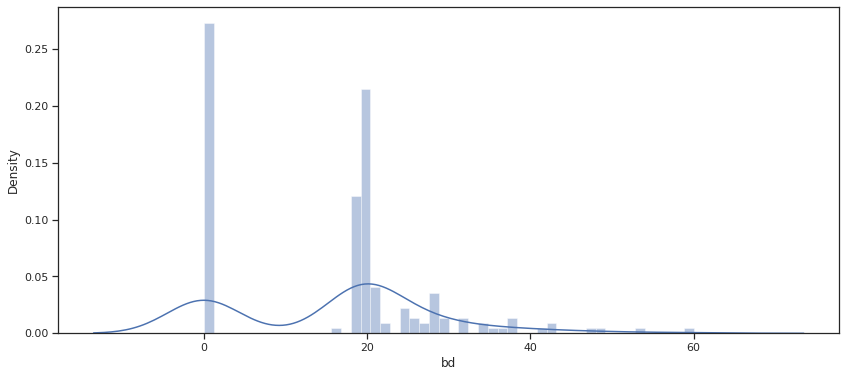

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(train.loc[train['bd'].value_counts()]['bd'].fillna(0),bins=50,color='b')

In [ ]:
print(pd.crosstab(train['is_churn'],train['gender']))

gender    female    male
is_churn                
0         160404  723226
1          23940   63390


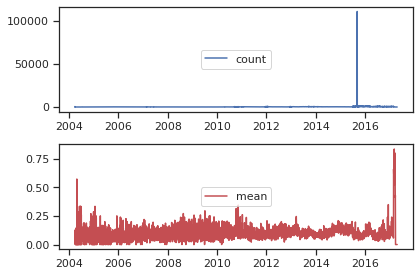

In [ ]:
regi = train.groupby('registration_init_time').count()['is_churn']
plt.subplot(211)
plt.plot(regi,color='b',label='count')
plt.legend(loc='center')
regi = train.groupby('registration_init_time').mean()['is_churn']
plt.subplot(212)
plt.plot(regi,color='r',label='mean')
plt.legend(loc='center')
plt.tight_layout()

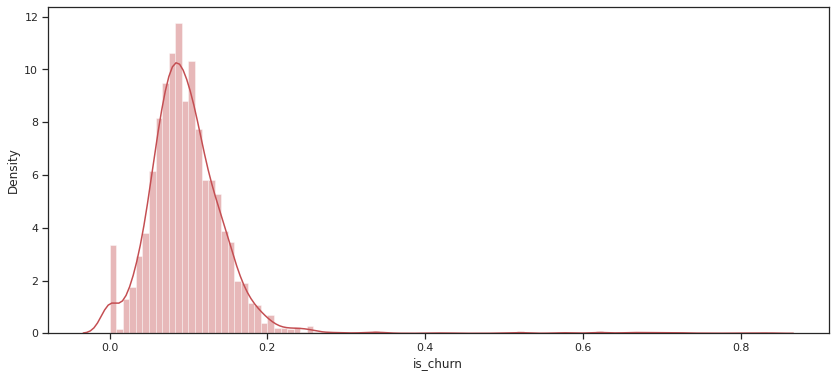

In [ ]:
regi = train.groupby('registration_init_time').mean()['is_churn']
plt.figure(figsize=(14,6))
sns.distplot(regi,bins=100,color='r')

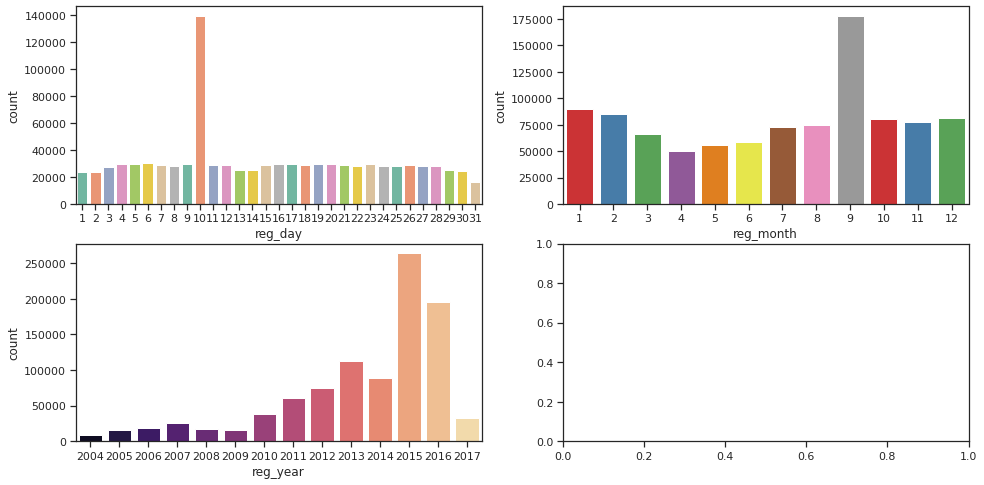

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['reg_day'],palette='Set2',ax=ax1)
sns.countplot(data=train,x='reg_month',palette='Set1',ax=ax2)
sns.countplot(data=train,x='reg_year',palette='magma',ax=ax3)

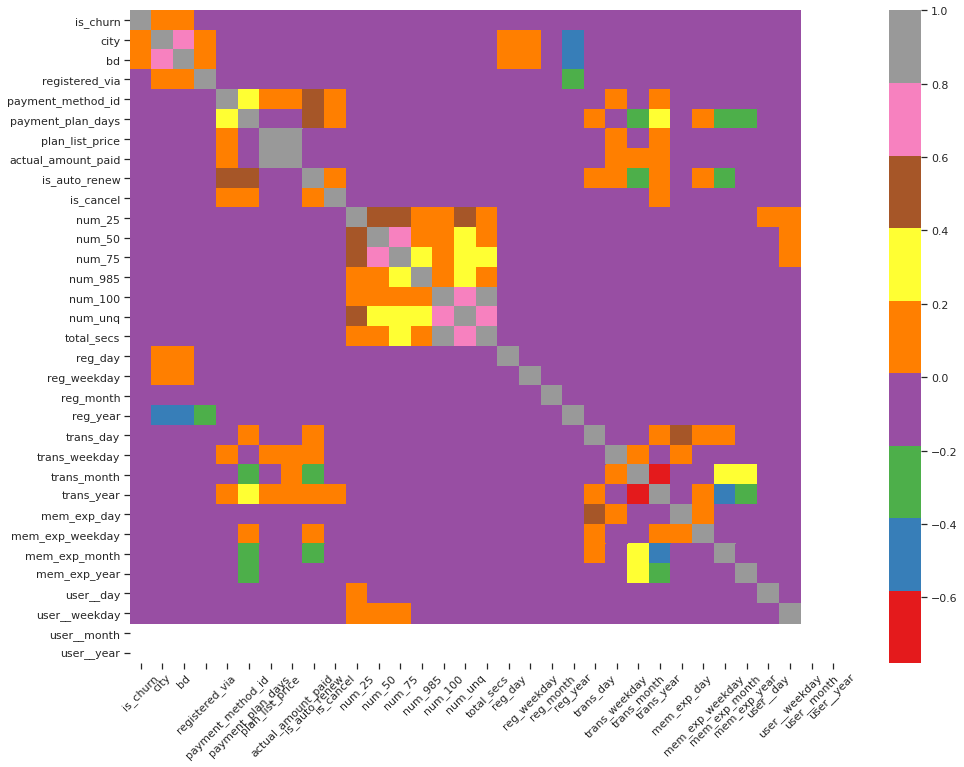

In [ ]:
cor = train.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cor,cmap='Set1',annot=False)
plt.xticks(rotation=45);

# Feature Engineering

In [ ]:
le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

In [ ]:
def OHE(df):

    col = ['city','gender','registered_via']
    print('Categorical columns in dataset',col)
    
    c2,c3 = [],{}
    for c in col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df,columns=c2,drop_first=True,prefix=c3)
    print(df.shape)
    return df
train1 = OHE(train)
test1 = OHE(test)

Categorical columns in dataset ['city', 'gender', 'registered_via']
(970960, 61)
Categorical columns in dataset ['city', 'gender', 'registered_via']
(907471, 61)


In [ ]:
! pip install sweetviz
import sweetviz as sv 
report=sv.analyze(train1)
Generating report
report.show_html('report.html')

# spliting data

In [ ]:
unwanted = ['msno','is_churn','registration_init_time','transaction_date','membership_expire_date','date']

X = train1.drop(unwanted,axis=1)
y = train1['is_churn'].astype('category')
x_test = test1.drop(unwanted,axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0)




```
# This is formatted as code
```

# Feature Scaling 

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Machine learning models without Data Augmentation

In [ ]:
model_lgr = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,lr_predict))

confussion matrix
[[88411     0]
 [ 8685     0]]
-------------------------------------------
Accuracy of Logistic Regression: 91.05524429430668 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     88411
           1       0.00      0.00      0.00      8685

    accuracy                           0.91     97096
   macro avg       0.46      0.50      0.48     97096
weighted avg       0.83      0.91      0.87     97096



In [ ]:
model_nb = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(nb_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,nbpred))

confussion matrix
[[74856 13555]
 [ 6124  2561]]
-------------------------------------------
Accuracy of Naive Bayes model: 79.7324297602373 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.85      0.88     88411
           1       0.16      0.29      0.21      8685

    accuracy                           0.80     97096
   macro avg       0.54      0.57      0.55     97096
weighted avg       0.86      0.80      0.82     97096



In [ ]:
model_rfc = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,rf_predicted))

confussion matrix
[[88411     0]
 [ 8685     0]]
-------------------------------------------
Accuracy of Random Forest: 91.05524429430668 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     88411
           1       0.00      0.00      0.00      8685

    accuracy                           0.91     97096
   macro avg       0.46      0.50      0.48     97096
weighted avg       0.83      0.91      0.87     97096



In [ ]:
model_egb = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("confussion matrix")
print(xgb_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Extreme Gradient Boost:",xgb_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,xgb_predicted))

confussion matrix
[[88411     0]
 [ 8685     0]]
-------------------------------------------
Accuracy of Extreme Gradient Boost: 91.05524429430668 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     88411
           1       0.00      0.00      0.00      8685

    accuracy                           0.91     97096
   macro avg       0.46      0.50      0.48     97096
weighted avg       0.83      0.91      0.87     97096



In [ ]:
'''
model_knn = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("-------------------------------------------")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,knn_predicted))
'''

'\nmodel_knn = \'K-NeighborsClassifier\'\nknn = KNeighborsClassifier(n_neighbors=10)\nknn.fit(X_train, y_train)\nknn_predicted = knn.predict(X_test)\nknn_conf_matrix = confusion_matrix(y_test, knn_predicted)\nknn_acc_score = accuracy_score(y_test, knn_predicted)\nprint("confussion matrix")\nprint(knn_conf_matrix)\nprint("-------------------------------------------")\nprint("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,\'\n\')\nprint("-------------------------------------------")\nprint(classification_report(y_test,knn_predicted))\n'

In [ ]:
model_dtc = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dt.fit(X_train, y_train)
dt_predicted = dt.predict(X_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_acc_score = accuracy_score(y_test, dt_predicted)
print("confussion matrix")
print(dt_conf_matrix)
print("-------------------------------------------")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,dt_predicted))

confussion matrix
[[88408     3]
 [ 8650    35]]
-------------------------------------------
Accuracy of DecisionTreeClassifier: 91.08820136771854 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     88411
           1       0.92      0.00      0.01      8685

    accuracy                           0.91     97096
   macro avg       0.92      0.50      0.48     97096
weighted avg       0.91      0.91      0.87     97096



In [ ]:
'''
model_svc = 'Support Vector Classifier'
svc =  SVC(kernel='rbf',gamma=0.1, C=1.0)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("confussion matrix")
print(svc_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Support Vector Classifier:",svc_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,svc_predicted))
'''

'\nmodel_svc = \'Support Vector Classifier\'\nsvc =  SVC(kernel=\'rbf\',gamma=0.1, C=1.0)\nsvc.fit(X_train, y_train)\nsvc_predicted = svc.predict(X_test)\nsvc_conf_matrix = confusion_matrix(y_test, svc_predicted)\nsvc_acc_score = accuracy_score(y_test, svc_predicted)\nprint("confussion matrix")\nprint(svc_conf_matrix)\nprint("-------------------------------------------")\nprint("Accuracy of Support Vector Classifier:",svc_acc_score*100,\'\n\')\nprint("-------------------------------------------")\nprint(classification_report(y_test,svc_predicted))\n'

In [ ]:
model_sgd = 'Stochastic Gradient Descent'
sgdc = SGDClassifier(max_iter=5000, random_state=0)
sgdc.fit(X_train, y_train)
sgdc_predicted = sgdc.predict(X_test)
sgdc_conf_matrix = confusion_matrix(y_test, sgdc_predicted)
sgdc_acc_score = accuracy_score(y_test, sgdc_predicted)
print("confussion matrix")
print(sgdc_conf_matrix)
print("-------------------------------------------")
print("Accuracy of : Stochastic Gradient Descent",sgdc_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,sgdc_predicted))

confussion matrix
[[88411     0]
 [ 8685     0]]
-------------------------------------------
Accuracy of : Stochastic Gradient Descent 91.05524429430668 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     88411
           1       0.00      0.00      0.00      8685

    accuracy                           0.91     97096
   macro avg       0.46      0.50      0.48     97096
weighted avg       0.83      0.91      0.87     97096



In [ ]:
'''
model_nn = 'Neural Nets'
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
mlpc.fit(X_train, y_train)
mlpc_predicted = mlpc.predict(X_test)
mlpc_conf_matrix = confusion_matrix(y_test, mlpc_predicted)
mlpc_acc_score = accuracy_score(y_test, mlpc_predicted)
print("confussion matrix")
print(mlpc_conf_matrix)
print("-------------------------------------------")
print("Accuracy of : MLP Classifier",mlpc_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,mlpc_predicted))
'''

'\nmodel_nn = \'Neural Nets\'\nmlpc = MLPClassifier(solver=\'lbfgs\', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)\nmlpc.fit(X_train, y_train)\nmlpc_predicted = mlpc.predict(X_test)\nmlpc_conf_matrix = confusion_matrix(y_test, mlpc_predicted)\nmlpc_acc_score = accuracy_score(y_test, mlpc_predicted)\nprint("confussion matrix")\nprint(mlpc_conf_matrix)\nprint("-------------------------------------------")\nprint("Accuracy of : MLP Classifier",mlpc_acc_score*100,\'\n\')\nprint("-------------------------------------------")\nprint(classification_report(y_test,mlpc_predicted))\n'

'\nplt.subplot(3,3,9)\nplt.title(\'is_churn --- Model: Neural Nets --- Accuracy:{x:.5f}\'.format(x=mlpc_acc_score))\nsns.heatmap(mlpc_conf_matrix, annot=True, cmap="Blues")\n'

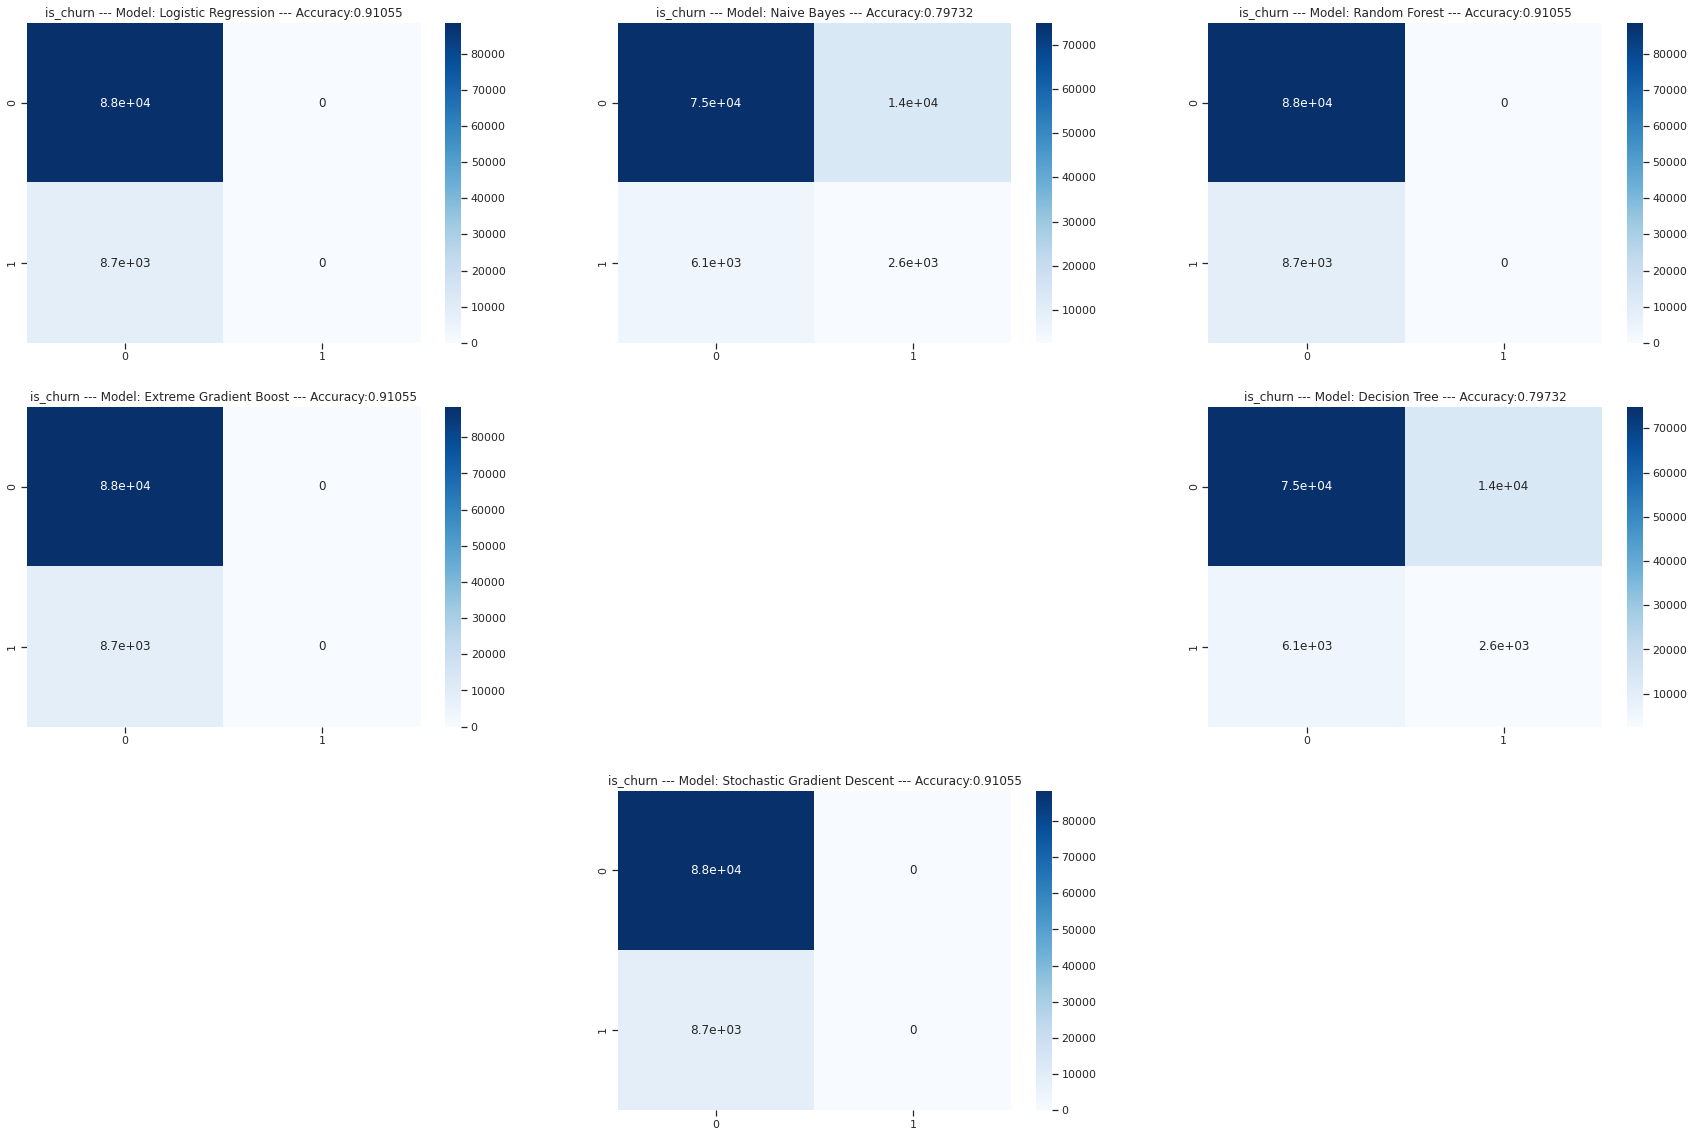

In [ ]:
plt.figure(figsize=(30,20))

plt.subplot(3,3,1)
plt.title('is_churn --- Model: Logistic Regression --- Accuracy:{x:.5f}'.format(x=lr_acc_score))
sns.heatmap(lr_conf_matrix, annot=True, cmap="Blues")

plt.subplot(3,3,2)
plt.title('is_churn --- Model: Naive Bayes --- Accuracy:{x:.5f}'.format(x=nb_acc_score))
sns.heatmap(nb_conf_matrix, annot=True, cmap="Blues")

plt.subplot(3,3,3)
plt.title('is_churn --- Model: Random Forest --- Accuracy:{x:.5f}'.format(x=rf_acc_score) )
sns.heatmap(rf_conf_matrix, annot=True, cmap="Blues")

plt.subplot(3,3,4)
plt.title('is_churn --- Model: Extreme Gradient Boost --- Accuracy:{x:.5f}'.format(x=xgb_acc_score))
sns.heatmap(xgb_conf_matrix, annot=True, cmap="Blues")
'''
plt.subplot(3,3,7)
plt.title('is_churn --- Model: K-Nearest Neighbour --- Accuracy:{x:.5f}'.format(x=knn_acc_score))
sns.heatmap(knn_conf_matrix, annot=True, cmap="Blues")
'''
plt.subplot(3,3,5)
plt.title('is_churn --- Model: Decision Tree --- Accuracy:{x:.5f}'.format(x=nb_acc_score))
sns.heatmap(nb_conf_matrix, annot=True, cmap="Blues")
'''
plt.subplot(3,3,8)
plt.title('is_churn --- Model: Support Vector Machine --- Accuracy:{x:.5f}'.format(x=svc_acc_score))
sns.heatmap(svc_conf_matrix, annot=True, cmap="Blues")
'''
plt.subplot(3,3,6)
plt.title('is_churn --- Model: Stochastic Gradient Descent --- Accuracy:{x:.5f}'.format(x=sgdc_acc_score))
sns.heatmap(sgdc_conf_matrix, annot=True, cmap="Blues")
'''
plt.subplot(3,3,9)
plt.title('is_churn --- Model: Neural Nets --- Accuracy:{x:.5f}'.format(x=mlpc_acc_score))
sns.heatmap(mlpc_conf_matrix, annot=True, cmap="Blues")
'''




# Evaluation of Models

In [ ]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','Naive Bayes','Random Forest','Extreme Gradient Boost',
                    'Decision Tree', 'Stochastic Gradient Descent'], 'Accuracy': [lr_acc_score*100,
                    nb_acc_score*100,rf_acc_score*100,xgb_acc_score*100,dt_acc_score*100, sgdc_acc_score*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,91.055244
1,Naive Bayes,79.732430
2,Random Forest,91.055244
3,Extreme Gradient Boost,91.055244
4,Decision Tree,91.088201
5,Stochastic Gradient Descent,91.055244


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

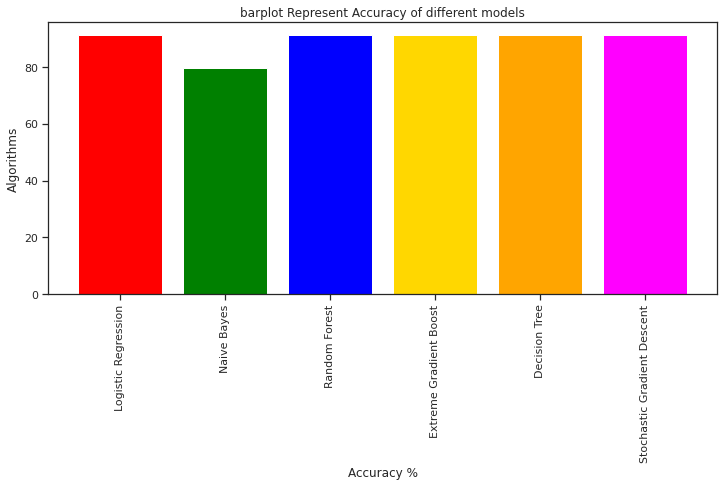

In [ ]:
colors = ['red','green','blue','gold','orange','magenta']
plt.figure(figsize=(12,5))
plt.title("barplot Represent Accuracy of different models")
plt.xlabel("Accuracy %")
plt.xticks(rotation=90)
plt.ylabel("Algorithms")
plt.bar(model_ev['Model'],model_ev['Accuracy'],color = colors)
plt.show()

# Conclusion

Decision Tree	 gave the best accuracy on test with the :91.088201%

# After Data Augmentation

In [ ]:
from collections import Counter
print("Before OverSampling, counts of label ': {}".format(Counter(y))) 
  

from imblearn.over_sampling import SVMSMOTE 
sm = SVMSMOTE(random_state = 2,sampling_strategy='auto',) 
X_res, y_res = sm.fit_resample(X, y.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape)) 
  

print("After OverSampling, counts of label ': {}".format(Counter(y_res))) 

Before OverSampling, counts of label ': Counter({0: 883630, 1: 87330})
After OverSampling, the shape of train_X: (1767260, 55)
After OverSampling, the shape of train_y: (1767260,) 

After OverSampling, counts of label ': Counter({1: 883630, 0: 883630})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res, test_size=0.1, random_state =0)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model_lgr = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,lr_predict))

confussion matrix
[[57397 31232]
 [20732 67365]]
-------------------------------------------
Accuracy of Logistic Regression: 70.59629030250217 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.65      0.69     88629
           1       0.68      0.76      0.72     88097

    accuracy                           0.71    176726
   macro avg       0.71      0.71      0.71    176726
weighted avg       0.71      0.71      0.70    176726



In [ ]:
model_nb = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(nb_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,nbpred))

confussion matrix
[[69509 19120]
 [43233 44864]]
-------------------------------------------
Accuracy of Naive Bayes model: 64.71769858424906 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.78      0.69     88629
           1       0.70      0.51      0.59     88097

    accuracy                           0.65    176726
   macro avg       0.66      0.65      0.64    176726
weighted avg       0.66      0.65      0.64    176726



In [ ]:
model_rfc = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,rf_predicted))

confussion matrix
[[66642 21987]
 [10807 77290]]
-------------------------------------------
Accuracy of Random Forest: 81.4435906431425 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.75      0.80     88629
           1       0.78      0.88      0.82     88097

    accuracy                           0.81    176726
   macro avg       0.82      0.81      0.81    176726
weighted avg       0.82      0.81      0.81    176726



In [ ]:
model_egb = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("confussion matrix")
print(xgb_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Extreme Gradient Boost:",xgb_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,xgb_predicted))

confussion matrix
[[88018   611]
 [12918 75179]]
-------------------------------------------
Accuracy of Extreme Gradient Boost: 92.34464651494405 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     88629
           1       0.99      0.85      0.92     88097

    accuracy                           0.92    176726
   macro avg       0.93      0.92      0.92    176726
weighted avg       0.93      0.92      0.92    176726



In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(xgb, open(filename, 'wb'))

In [ ]:
'''
model_knn = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("-------------------------------------------")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,knn_predicted))
'''

'\nmodel_knn = \'K-NeighborsClassifier\'\nknn = KNeighborsClassifier(n_neighbors=10)\nknn.fit(X_train, y_train)\nknn_predicted = knn.predict(X_test)\nknn_conf_matrix = confusion_matrix(y_test, knn_predicted)\nknn_acc_score = accuracy_score(y_test, knn_predicted)\nprint("confussion matrix")\nprint(knn_conf_matrix)\nprint("-------------------------------------------")\nprint("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,\'\n\')\nprint("-------------------------------------------")\nprint(classification_report(y_test,knn_predicted))\n'

In [ ]:

model_dtc = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dt.fit(X_train, y_train)
dt_predicted = dt.predict(X_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_acc_score = accuracy_score(y_test, dt_predicted)
print("confussion matrix")
print(dt_conf_matrix)
print("-------------------------------------------")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,dt_predicted))

confussion matrix
[[75595 13034]
 [18461 69636]]
-------------------------------------------
Accuracy of DecisionTreeClassifier: 82.17862680081029 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.85      0.83     88629
           1       0.84      0.79      0.82     88097

    accuracy                           0.82    176726
   macro avg       0.82      0.82      0.82    176726
weighted avg       0.82      0.82      0.82    176726



In [ ]:
'''
model_svc = 'Support Vector Classifier'
svc =  SVC(kernel='rbf',gamma=0.1, C=1.0)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("confussion matrix")
print(svc_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Support Vector Classifier:",svc_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,svc_predicted))
'''

'\nmodel_svc = \'Support Vector Classifier\'\nsvc =  SVC(kernel=\'rbf\',gamma=0.1, C=1.0)\nsvc.fit(X_train, y_train)\nsvc_predicted = svc.predict(X_test)\nsvc_conf_matrix = confusion_matrix(y_test, svc_predicted)\nsvc_acc_score = accuracy_score(y_test, svc_predicted)\nprint("confussion matrix")\nprint(svc_conf_matrix)\nprint("-------------------------------------------")\nprint("Accuracy of Support Vector Classifier:",svc_acc_score*100,\'\n\')\nprint("-------------------------------------------")\nprint(classification_report(y_test,svc_predicted))\n'

In [ ]:
model_sgd = 'Stochastic Gradient Descent'
sgdc = SGDClassifier(max_iter=5000, random_state=0)
sgdc.fit(X_train, y_train)
sgdc_predicted = sgdc.predict(X_test)
sgdc_conf_matrix = confusion_matrix(y_test, sgdc_predicted)
sgdc_acc_score = accuracy_score(y_test, sgdc_predicted)
print("confussion matrix")
print(sgdc_conf_matrix)
print("-------------------------------------------")
print("Accuracy of : Stochastic Gradient Descent",sgdc_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,sgdc_predicted))

confussion matrix
[[55421 33208]
 [17283 70814]]
-------------------------------------------
Accuracy of : Stochastic Gradient Descent 71.4297839593495 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.63      0.69     88629
           1       0.68      0.80      0.74     88097

    accuracy                           0.71    176726
   macro avg       0.72      0.71      0.71    176726
weighted avg       0.72      0.71      0.71    176726



In [ ]:
'''
model_nn = 'Neural Nets'
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
mlpc.fit(X_train, y_train)
mlpc_predicted = mlpc.predict(X_test)
mlpc_conf_matrix = confusion_matrix(y_test, mlpc_predicted)
mlpc_acc_score = accuracy_score(y_test, mlpc_predicted)
print("confussion matrix")
print(mlpc_conf_matrix)
print("-------------------------------------------")
print("Accuracy of : MLP Classifier",mlpc_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,mlpc_predicted))
'''

'\nmodel_nn = \'Neural Nets\'\nmlpc = MLPClassifier(solver=\'lbfgs\', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)\nmlpc.fit(X_train, y_train)\nmlpc_predicted = mlpc.predict(X_test)\nmlpc_conf_matrix = confusion_matrix(y_test, mlpc_predicted)\nmlpc_acc_score = accuracy_score(y_test, mlpc_predicted)\nprint("confussion matrix")\nprint(mlpc_conf_matrix)\nprint("-------------------------------------------")\nprint("Accuracy of : MLP Classifier",mlpc_acc_score*100,\'\n\')\nprint("-------------------------------------------")\nprint(classification_report(y_test,mlpc_predicted))\n'

'\nplt.subplot(3,3,9)\nplt.title(\'is_churn --- Model: Neural Nets --- Accuracy:{x:.5f}\'.format(x=mlpc_acc_score))\nsns.heatmap(mlpc_conf_matrix, annot=True, cmap="Blues")\n'

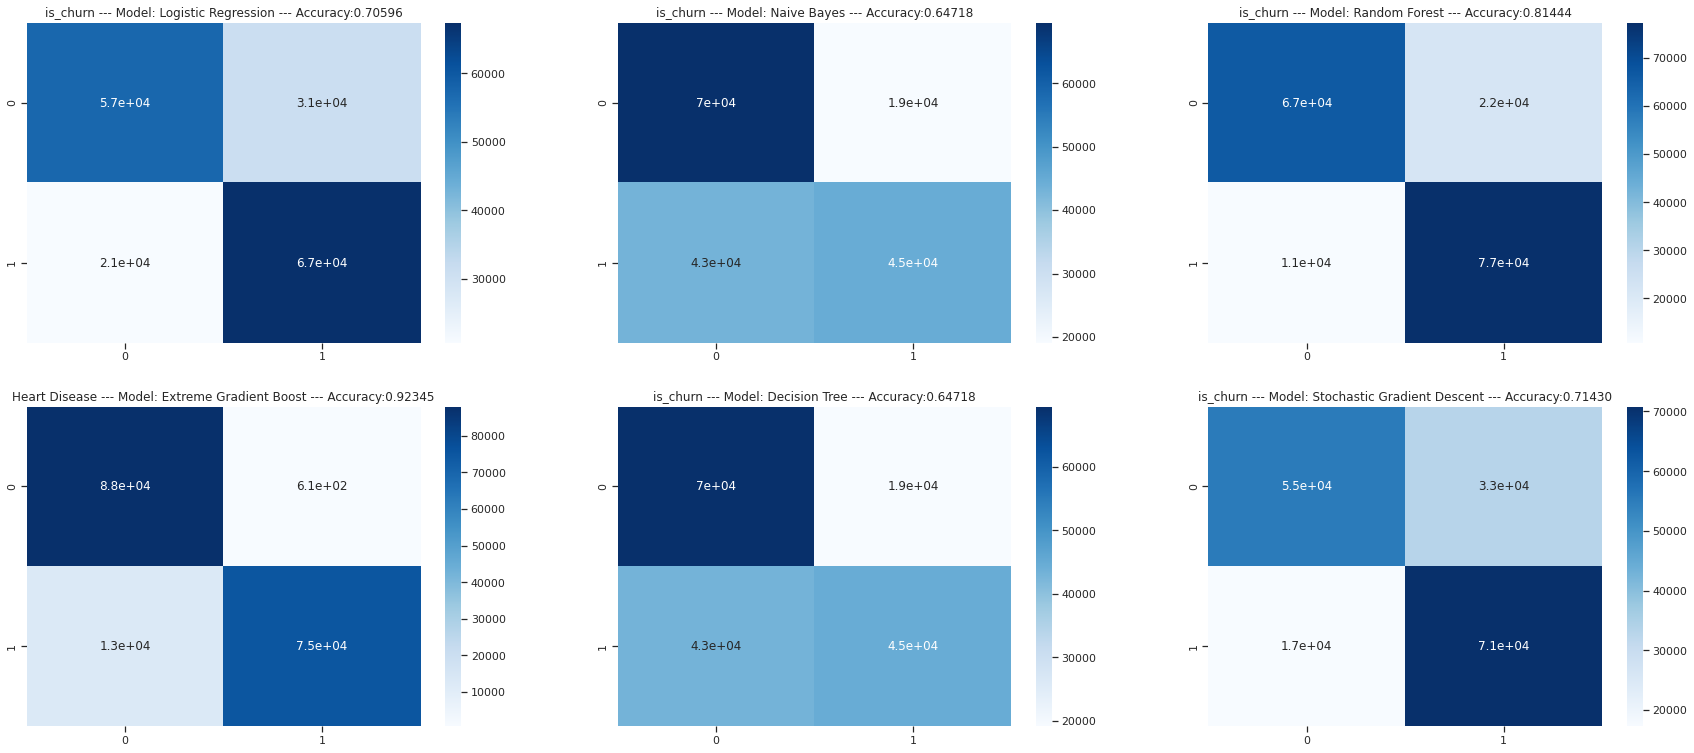

In [ ]:
plt.figure(figsize=(30,20))

plt.subplot(3,3,1)
plt.title('is_churn --- Model: Logistic Regression --- Accuracy:{x:.5f}'.format(x=lr_acc_score))
sns.heatmap(lr_conf_matrix, annot=True, cmap="Blues")

plt.subplot(3,3,2)
plt.title('is_churn --- Model: Naive Bayes --- Accuracy:{x:.5f}'.format(x=nb_acc_score))
sns.heatmap(nb_conf_matrix, annot=True, cmap="Blues")

plt.subplot(3,3,3)
plt.title('is_churn --- Model: Random Forest --- Accuracy:{x:.5f}'.format(x=rf_acc_score) )
sns.heatmap(rf_conf_matrix, annot=True, cmap="Blues")

plt.subplot(3,3,4)
plt.title('Heart Disease --- Model: Extreme Gradient Boost --- Accuracy:{x:.5f}'.format(x=xgb_acc_score))
sns.heatmap(xgb_conf_matrix, annot=True, cmap="Blues")
'''
plt.subplot(3,3,5)
plt.title('is_churn --- Model: K-Nearest Neighbour --- Accuracy:{x:.5f}'.format(x=knn_acc_score))
sns.heatmap(knn_conf_matrix, annot=True, cmap="Blues")
'''
plt.subplot(3,3,5)
plt.title('is_churn --- Model: Decision Tree --- Accuracy:{x:.5f}'.format(x=nb_acc_score))
sns.heatmap(nb_conf_matrix, annot=True, cmap="Blues")
'''
plt.subplot(3,3,7)
plt.title('is_churn --- Model: Support Vector Machine --- Accuracy:{x:.5f}'.format(x=svc_acc_score))
sns.heatmap(svc_conf_matrix, annot=True, cmap="Blues")
'''
plt.subplot(3,3,6)
plt.title('is_churn --- Model: Stochastic Gradient Descent --- Accuracy:{x:.5f}'.format(x=sgdc_acc_score))
sns.heatmap(sgdc_conf_matrix, annot=True, cmap="Blues")
'''
plt.subplot(3,3,9)
plt.title('is_churn --- Model: Neural Nets --- Accuracy:{x:.5f}'.format(x=mlpc_acc_score))
sns.heatmap(mlpc_conf_matrix, annot=True, cmap="Blues")
'''

In [ ]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','Naive Bayes','Random Forest','Extreme Gradient Boost',
                    'Decision Tree', 'Stochastic Gradient Descent'], 'Accuracy': [lr_acc_score*100,
                    nb_acc_score*100,rf_acc_score*100,xgb_acc_score*100,dt_acc_score*100, sgdc_acc_score*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,70.596290
1,Naive Bayes,64.717699
2,Random Forest,81.443591
3,Extreme Gradient Boost,92.344647
4,Decision Tree,82.178627
5,Stochastic Gradient Descent,71.429784


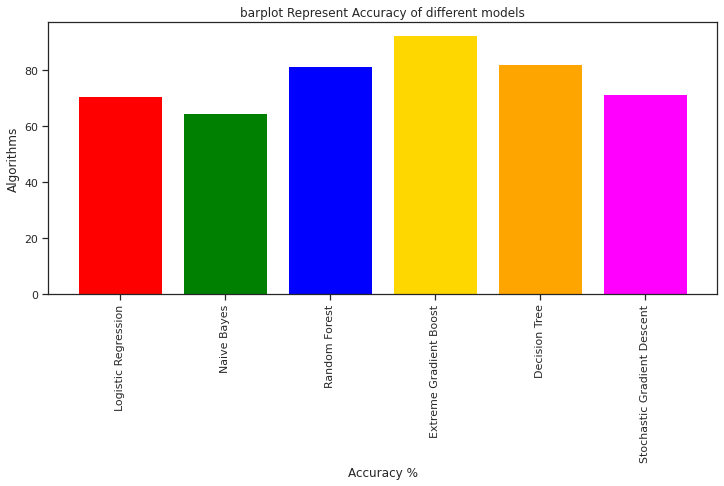

In [ ]:
colors = ['red','green','blue','gold','orange','magenta']
plt.figure(figsize=(12,5))
plt.title("barplot Represent Accuracy of different models")
plt.xlabel("Accuracy %")
plt.xticks(rotation=90)
plt.ylabel("Algorithms")
plt.bar(model_ev['Model'],model_ev['Accuracy'],color = colors)
plt.show()

# Conclusion

Extreme Gradient Boost gave the best accuracy on test with the :92.3% 